In [1]:
from mumag3 import *
from magpi.prelude import *
import matplotlib.pyplot as plt
from scipy.stats.qmc import Halton
from magpi.integrate import gauss
from matplotlib.ticker import FormatStrFormatter
import numpy as np

jax.config.update('jax_platform_name', 'gpu')
jax.config.update("jax_enable_x64", False)
%matplotlib widget

key = random.PRNGKey(42)

# NIST $\mu$ Mag Standard Problem #3

In this notebook we solve the NIST $\mu$ Mag Standard Problem #3 via a hard constraint PINN ansatz for the magnetization, whereas the stray field is computed via hard constraint ELMs and the 
single layer potential.

First we define two initial magnetization states for the flower and the vortex state.
For each initial state a separate model is then trainied to learn the magnetic configuration dependent on the exchange lenght which is a conditional parameter for the network.
Minimization is done via SGD.

In [2]:
def m_vortex(x):
    x, y, z = x[..., 0], x[..., 1], x[..., 2]
    rc = 0.14
    r = sqrt(z ** 2 + x ** 2)
    k = r**2 / rc**2

    my = exp(-2 * k)
    mx = - z / r * sqrt(1 - exp(-4 * k))
    mz = x / r * sqrt(1 - exp(-4 * k))

    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)

def m_flower(x):
    mx = x[..., 0] * x[..., 2]
    my = x[..., 1] * x[..., 2]# + (1 / 2 * x[..., 1] * x[..., 2]) ** 3
    mz = ones_like(my)
    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)

Then we compute the source tensor. Note that this uses an older implementation which is slightly faster, but less generic. For an up-to-date version we can also use `surface_integral` module of MagPI.

In [3]:
domain = Cuboid(
    linspace(-0.5, 0.5, 7),
    linspace(-0.5, 0.5, 7),
    linspace(-0.5, 0.5, 7)
)

x_dom = array(Halton(3, seed=124).random(2**13))
x_dom = domain.transform(x_dom)


x_tensor_dom = lax.map(
    lambda x: surface_tensors_grad(x, domain, 15, gauss(5)), 
    x_dom
)

Next we define the hard constraint PINN model with Cayley transform and the ELM weights, as well as all energy terms. Finally the loss is defined. It takes the trainable model parameter, a trainingsbatch of collocation points and exchange lengths and an initial magnetization and returns the mean energy over this trainingbatch.

In [4]:
_weights = array(Halton(4, seed=1362).random(2 ** 9))
W_elm = (_weights[:, :3] * 2 - 1) * 2
b_elm = (_weights[:, 3] * 2 - 1) * 2

stray_field_solver = create_stray_field_solver(
    x_dom, domain, W_elm, b_elm,
    use_precomputed_grad_tensors=True
)

class PINN(nn.Module):
    @nn.compact
    def __call__(self, x, lam):
        nodes = 50
        activation = nn.gelu
        y = concatenate([x, lam.ravel()])
        y = activation(nn.Dense(nodes, name="dense1")(y))
        y = activation(nn.Dense(nodes, name="dense2")(y))
        y = activation(nn.Dense(nodes, name="dense3")(y))
        y = activation(nn.Dense(nodes, name="dense4")(y))
        y = activation(nn.Dense(nodes, name="dense5")(y))
        y = activation(nn.Dense(nodes, name="dense6")(y))
        y = nn.Dense(3, name="dense7")(y)
        return y

key, _k = random.split(key)
mag_pinn_model = PINN()
pinn_params_init = mag_pinn_model.init(_k, zeros((3,)), zeros(()))


def mag(mag0, x, lam, params):
    x = domain.normalize(x)
    p = mag_pinn_model.apply(params, x, lam)
    m = mag0(x)
    return cayley_rotation(p, m)

def exchange_energy(m, x, lam):
    A = 1 / (lam ** 2)
    def e_ex(x):
        dm = jacfwd(m)(x)
        return jnp.sum(dm * dm)
    return A * mean(vmap(e_ex)(x))

def ani_energy(m, x):
    def e_ani(x):
        c = array([0., 0., 1.])
        return 1 - (m(x) @ c) ** 2

    return 0.1 * mean(vmap(e_ani)(x))

def mag_energy(hs, m, x, xt):
    def e_mag(x, xt):
        e = lambda x: dot(m(x), hs(x, xt))
        return e(x)

    return - mean(vmap(e_mag)(x, xt))

@partial(jit, static_argnames="mag0")
def loss(params, data, mag0):
    x, xt, lam = data
    lam = array(lam)
    def _loss(lam):
        m = lambda x: mag(mag0, x, lam, params)
        _m = lambda x: mag(mag0, x, lam, lax.stop_gradient(params))
        hs = stray_field_solver(_m)
        e_ex = exchange_energy(m, x, lam)
        e_ani = ani_energy(m, x)
        e_mag = mag_energy(hs, m, x, xt)
        l = e_ex + e_ani + 2 * e_mag
        return l, {
            'e_tot': e_ex + e_ani + e_mag,
            'e_mag': e_mag,
            'e_ex': e_ex,
            'e_ani': e_ani,
        }
    return tree_map(mean, vmap(_loss)(lam))
    

Now it is time to define the trainingloop. Note that we iterate over all collocation points in one epoch, but the exchange length is uniformly sampled within $[8,9]$

In [5]:
from magpi.opt import batches_without_replacement

batch_size_dom = 500
batch_size_lam = 5



def train(key, optimizer, params, mag0, epochs, batch_size_dom, batch_size_lam):
    @jit
    def update(params, opt_state, data):
        (_loss, _aux), grads = value_and_grad(loss, has_aux=True)(params, data, mag0)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, (_loss, _aux)
    
    opt_state = optimizer.init(params)
    losses = []
    energies = []
    for epoch in range(epochs):
        key, k1, k2 = random.split(key, 3)
        x, xt = batches_without_replacement(k1, (x_dom, x_tensor_dom), batch_size_dom)
        batches = x.shape[0]
        lam = random.uniform(k2, (batches, batch_size_lam), minval=8, maxval=9)
        _losses = []
        _energies = []
        
        for batch in range(batches):
            data = tree_map(lambda a: a[batch], (x, xt, lam))
            params, opt_state, (_loss, _aux) = update(params, opt_state, data)
            _losses.append(_loss)
            _energies.append(_aux)
            
        losses.append(mean(asarray(_losses)))
        energies.append(tree_map(lambda *a: mean(asarray(a)), *_energies))
        
    losses = asarray(losses)
    energies = (tree_map(lambda *a: stack(a), *energies))
    return params, (losses, energies)

We run the loop for 6000 epochs for the flower and vortex state. 

In [6]:
epochs_flower = 6000
_reductions = 3
_n_batches = x_dom.shape[0] // batch_size_dom
_transition_steps = _n_batches * epochs_flower / _reductions
schedule = optax.exponential_decay(1e-5, _transition_steps, 0.1)
optimizer = optax.adamw(schedule)

key, train_key = random.split(key)
params_flower, (losses_flower, energies_flower) = train(
    train_key, optimizer, pinn_params_init, m_flower, epochs_flower, batch_size_dom, batch_size_lam
)

In [7]:

epochs_vortex = 6000
_reductions = 2
_n_batches = x_dom.shape[0] // batch_size_dom
_transition_steps = _n_batches * epochs_vortex / _reductions
schedule = optax.exponential_decay(1e-4, _transition_steps, 0.1)
optimizer = optax.adamw(schedule)

key, train_key = random.split(key)
params_vortex, (losses_vortex, energies_vortex) = train(
    train_key, optimizer, pinn_params_init, m_vortex, epochs_vortex, batch_size_dom, batch_size_lam)

Now we can plot the result:

In [8]:
import dataclasses
@dataclasses.dataclass(frozen=True,eq=False)
class Plot:
    name: str
    label: str
    data: Array

In [9]:

plt.rcParams.update({'font.size': 12})

def plot_hist(data):
    fig = plt.figure(figsize=(7, 5.5))
    axes = fig.subplots(4, 1)
    for i, p in enumerate(data):
        axes[i].plot(p.data)
        axes[i].set_xscale("log")
        axes[i].set_ylabel(p.label)
        axes[i].grid(which='both')
        if i != 3:
            axes[i].set_xticklabels([])
        start, end = axes[i].get_ylim()
        axes[i].yaxis.set_ticks(np.linspace(start, end, 5))
        axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes[-1].set_xlabel('epochs')
    fig.tight_layout()
    return fig

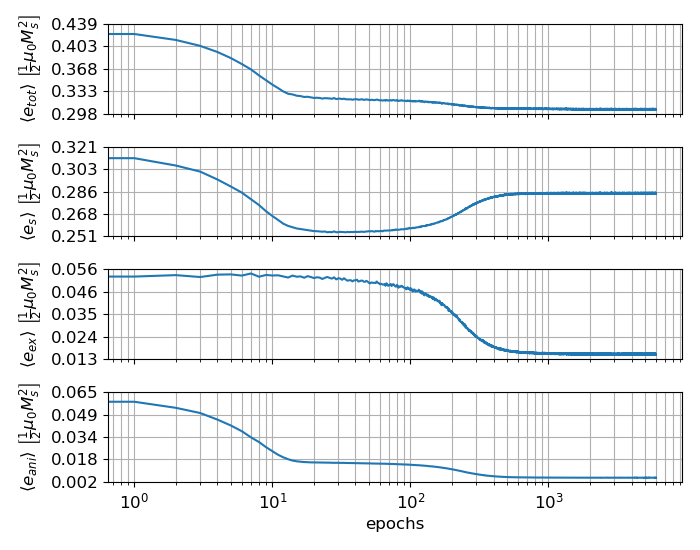

In [10]:
plots_flower = [
    Plot("$e_{tot}$", '$\\langle e_{tot}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_flower['e_tot']),
    Plot("$e_s$", '$\\langle e_{s}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_flower['e_mag']),
    Plot("$e_{ex}$", '$\\langle e_{ex}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_flower['e_ex']),
    Plot("$e_{a}$", '$\\langle e_{ani}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_flower['e_ani']),
]

fig_flower = plot_hist(plots_flower)

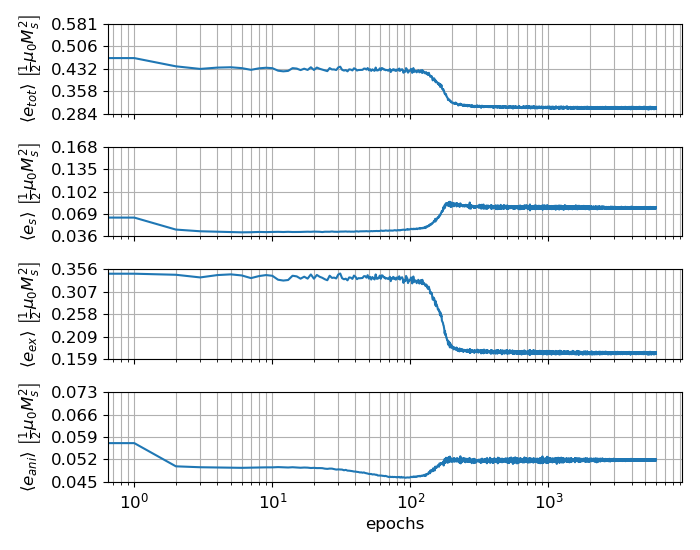

In [11]:
plots_vortex = [
    Plot("$e_{tot}$", '$\\langle e_{tot}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_vortex['e_tot']),
    Plot("$e_s$", '$\\langle e_{s}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_vortex['e_mag']),
    Plot("$e_{ex}$", '$\\langle e_{ex}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_vortex['e_ex']),
    Plot("$e_{a}$", '$\\langle e_{ani}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_vortex['e_ani']),
]

fig_vortex = plot_hist(plots_vortex)

In [12]:
_x_dom = array(Halton(3, seed=121).random(2**13))
_x_dom = domain.transform(_x_dom)
_x_tensor_dom = lax.map(lambda x: surface_tensors_grad(x, domain, 15, gauss(5)), _x_dom)


@partial(jit, static_argnames='mag0')
def total_energy(mag0, params, lam):
    lam = array(lam)
    m = lambda x: mag(mag0, x, lam, params)
    hs = stray_field_solver(m)
    e_ex = exchange_energy(m, _x_dom, lam)
    e_ani = ani_energy(m, _x_dom)
    e_mag = mag_energy(hs, m, _x_dom, _x_tensor_dom)
    e_tot = e_ex + e_ani + e_mag
    return {
        'e_tot': e_tot,
        'e_mag': e_mag,
        'e_ex': e_ex,
        'e_ani': e_ani,
    }
    
def e(mag0, params, lam):
    return total_energy(mag0, params, lam)['e_tot']

lam = jnp.arange(8, 9.01, 0.1)

_energies_flower = lax.map(lambda l: e(m_flower, params_flower, l), lam)
_energies_vortex = lax.map(lambda l: e(m_vortex, params_vortex, l), lam)

In [13]:
import numpy as np
from scipy.optimize import bisect

def _e_flower(lam):
    return np.array(e(m_flower, params_flower, lam))

def _e_vortex(lam):
    return np.array(e(m_vortex, params_vortex, lam))

def energy_difference(lam):
    vortex = _e_vortex(array(lam))
    flower = _e_flower(array(lam))
    return vortex - flower

cross_section = array(bisect(energy_difference, 8., 9.))
cross_section_energy = e(m_flower, params_flower, cross_section)
cross_section

Array(8.444602, dtype=float32, weak_type=True)

In [17]:
def format_arr(a):
    a = np.array(a)
    a = np.round(a, 4)
    if len(a.shape) == 0:
        return f"{a:.4f}"
    return np.array_str(a, precision=4, suppress_small=True)

print(tree_map(format_arr, total_energy(m_flower, params_flower, cross_section)))
print(tree_map(format_arr, total_energy(m_vortex, params_vortex, cross_section)))

{'e_ani': '0.0051', 'e_ex': '0.0158', 'e_mag': '0.2841', 'e_tot': '0.3050'}
{'e_ani': '0.0522', 'e_ex': '0.1737', 'e_mag': '0.0791', 'e_tot': '0.3050'}


In [18]:
def mean_mag(mag0, params, lam):
    def m(x):
        return mag(mag0, x, lam, params)
    return mean(vmap(m)(_x_dom), axis=0)
    

print("Mean Mag flower state: ", format_arr(mean_mag(m_flower, params_flower, cross_section)))
print("Mean Mag vortex state: ", format_arr(mean_mag(m_vortex, params_vortex, cross_section)))

Mean Mag flower state:  [ 0.0002 -0.0033  0.9737]
Mean Mag vortex state:  [0.008  0.3508 0.0029]


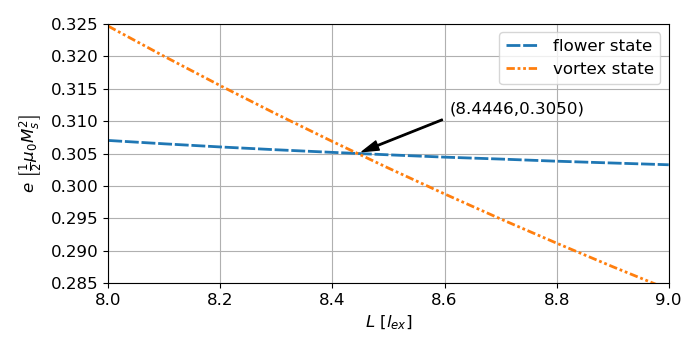

In [19]:
from matplotlib.ticker import FormatStrFormatter


fig = plt.figure(figsize=(7,3.5))


ax = fig.subplots(1,1)
ax.plot(lam, _energies_flower, linestyle=(0, (5, 1)), linewidth=2, label="flower state")
ax.plot(lam, _energies_vortex, linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=2, label="vortex state")
ax.set_xlim((8., 9.))
ax.set_ylim((0.285, 0.325))
ax.legend()
ax.grid()
ax.set_xlabel("$L$ $\\left[l_{ex}\\right]$")
ax.set_ylabel("$e$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$")
ax.yaxis.set_major_formatter(FormatStrFormatter('%0.3f'))
ax.tick_params(axis='both', which='major')

ax.annotate(f"({cross_section:.4f},{cross_section_energy:.4f})", xy=(cross_section,cross_section_energy),  xycoords='data',
            xytext=(0.85, 0.7), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1,headwidth=7),
            horizontalalignment='right', verticalalignment='top', size=12
            )
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 9))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
fig.tight_layout()